## NW Alignment distributions for sentences

* "Documents" stored are lists of lemmas extracted from sentences in each minutes/txt or SPLIT_NORM document
* Catalan/English stop words removed
* Named Entities replaced with tags "QUANT, DATE, MISC, PER, LOC, ORG"
* The distribution is left-skewed, indicating most documents are relatively dissimilar.

**Important note: These scores are not scaled by length of the documents. Similar documents which are long will have a much higher score than shorter documents which are similar. The opposite is also true: longer documents which are extremely dissimilary will have much lower scores than shorter documents which are dissimilar.**

In [29]:
import psycopg2
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import json

database = 'gaceta'
conn = psycopg2.connect("dbname=" + database + " user=abarciauskas")
cur = conn.cursor()

cur.execute("SELECT Doc1Id,Doc2Id,Score FROM alignments ORDER BY random() LIMIT 100000")
scores = cur.fetchall()

In [30]:
score_list = [score[2] for score in scores]
# remove very different scores, this is heuristic
# FIXME: make it not a heuristic but remove all those < -5 s.d.s or some such
score_list = [item for item in score_list if item > -200]

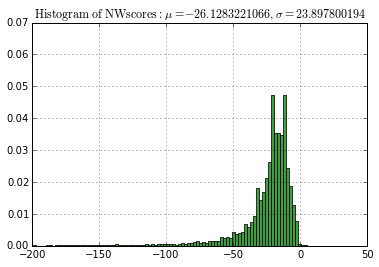

In [31]:
%matplotlib inline

# the histogram of the data
n, bins, patches = plt.hist(score_list, 100, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(score_list)
sigma = np.std(score_list)
plt.title(r'$\mathrm{Histogram\ of\ NW scores:}\ \mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
# Note: there is a value lower, ths has cut some extremes
plt.axis([-200, 50, 0, 0.07])
plt.grid(True)

plt.show()

In [32]:
# get 10 pairs from each +/-1,2,3 standard deviations around the mean
sd_range = range(-3,3)
ranges = []
for i in sd_range:
    ranges.append((int(mu+i*sigma), int(mu+(i+1)*sigma)))

sd_sets = dict((el,[]) for el in ranges)

range_keys = sd_sets.keys()
ranges = [range(x[0], x[1]) for x in range_keys]

for score_tuple in scores:
    docid1, docid2, score = score_tuple
    bucket_idx = [i for i in range(len(ranges)) if score in ranges[i]]
    if len(bucket_idx) == 1:
        bucket_idx = bucket_idx[0]
        sd_sets[range_keys[bucket_idx]].append([docid1,docid2,score])

cur = conn.cursor()

from pprint import pprint

select_total = 10
tasks = []
question = "Are these sentences redundant?"
for key in range_keys:
    doc_pairs = sd_sets[key][0:10]
    for pair in doc_pairs:
        doc1 = cur.execute("SELECT Id,Original,FileName FROM processed_documents WHERE Id = " + str(pair[0]))
        doc1 = cur.fetchone()
        doc2 = cur.execute("SELECT Id,Original FROM processed_documents WHERE Id = " + str(pair[1]))
        doc2 = cur.fetchone()
        task = {
                'question': question,
                'doc1id': doc1[0],
                'doc1': doc1[1],
                'doc2id': doc2[0],
                'doc2': doc2[1],
                'filename': doc1[2],
                'nw_score': pair[2]
            }
        tasks.append(task)

print "Number of tasks collected: " + str(len(tasks))
with open(database + "_tasks.json", "w+") as jsonfile:
    json.dump(tasks, jsonfile)

cur.close()
conn.close()

Number of tasks collected: 60
